In [3]:
#  Cell 1: Clean install & import libraries, mount Drive

# Update pip first
!pip install -U pip --quiet

# Colab already includes tensorflow, matplotlib, sklearn, seaborn
# We only need to add cv2 (opencv-python-headless) safely
!pip install -q opencv-python-headless tensorflow_hub

# Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 31.6 MB/s eta 0:00:00
Mounted at /content/drive


In [4]:
# Cell 2: Load sample images and define utility for display
# Correct path to your dataset inside Google Drive
data_path = '/content/drive/MyDrive/Plant Disease segmentation/dataset1'

# Utility function to display images
def show_image(title, img, cmap=None):
    plt.figure(figsize=(6,6))
    plt.title(title)
    if cmap:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Automatically detect all class folders
class_folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]

print("Detected class folders:", class_folders)

Detected class folders: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


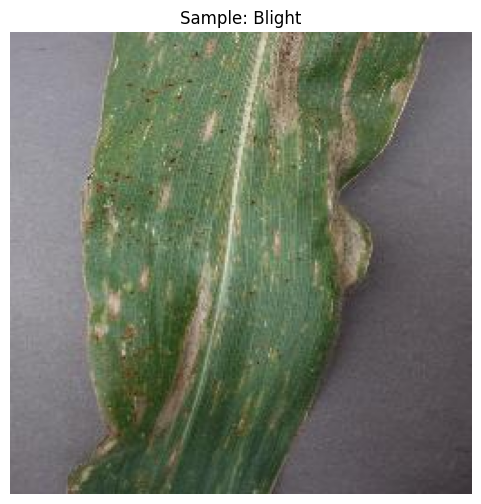

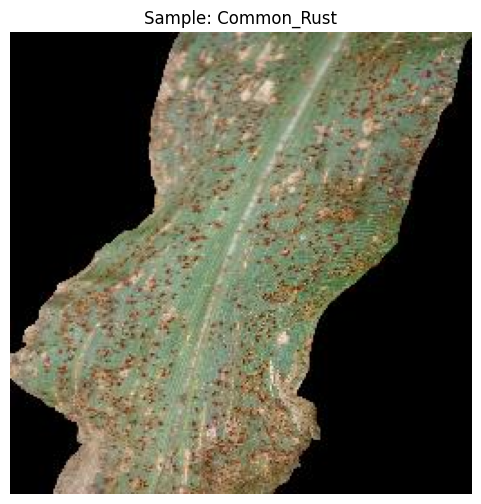

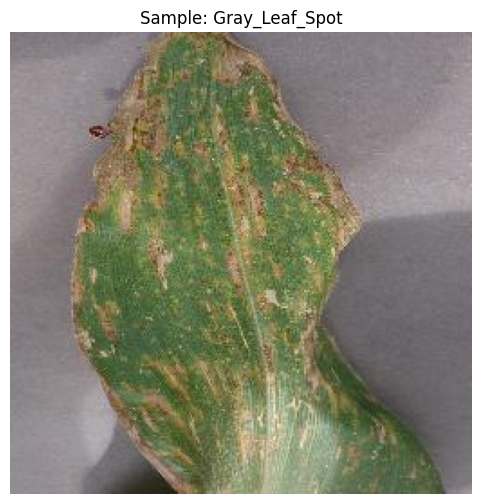

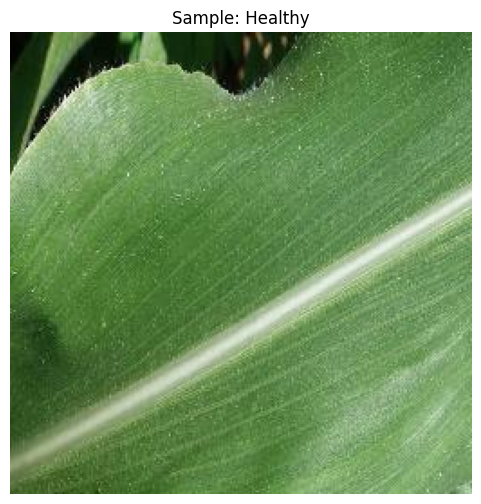

In [5]:
# Load and display one sample image per class
for class_name in class_folders:
    folder_path = os.path.join(data_path, class_name)
    image_files = os.listdir(folder_path)
    if len(image_files) == 0:
        print(f"No images found in {class_name}")
        continue
    img_path = os.path.join(folder_path, image_files[0])
    img = cv2.imread(img_path)
    if img is not None:
        show_image(f"Sample: {class_name}", img)
    else:
        print(f" Could not read image from {img_path}")


In [6]:
# Cell 3: Part A - Grayscale, Adaptive thresholding, Morphological operations and contour detection

import cv2
import numpy as np

# --- Utility: segmentation function ---
def segment_leaf(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        11, 2
    )
    kernel = np.ones((5,5), np.uint8)
    morph = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    return morph


In [7]:
# --- Select one healthy and one diseased sample for demonstration ---
# NOTE: change these if you want different categories
healthy_path = os.path.join(data_path, 'Healthy', os.listdir(os.path.join(data_path, 'Healthy'))[0])
diseased_path = os.path.join(data_path, 'Common_Rust', os.listdir(os.path.join(data_path, 'Common_Rust'))[0])

healthy_img = cv2.imread(healthy_path)
diseased_img = cv2.imread(diseased_path)

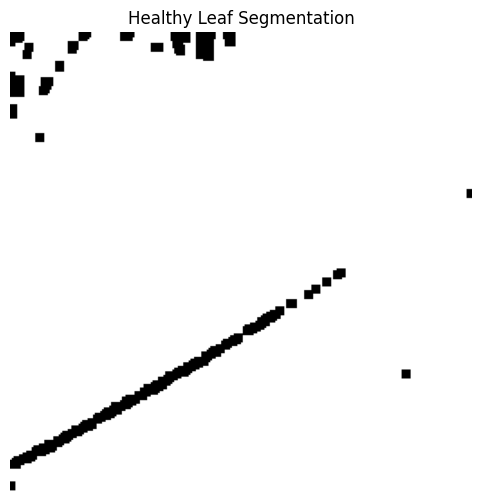

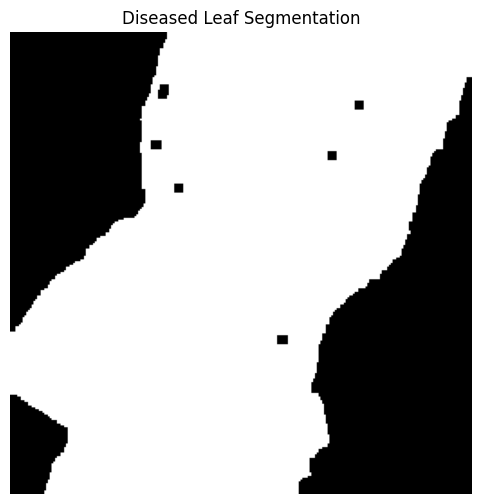

In [8]:
# --- Segment both images ---
healthy_seg = segment_leaf(healthy_img)
diseased_seg = segment_leaf(diseased_img)

# --- Display segmented images ---
show_image('Healthy Leaf Segmentation', healthy_seg, cmap='gray')
show_image('Diseased Leaf Segmentation', diseased_seg, cmap='gray')

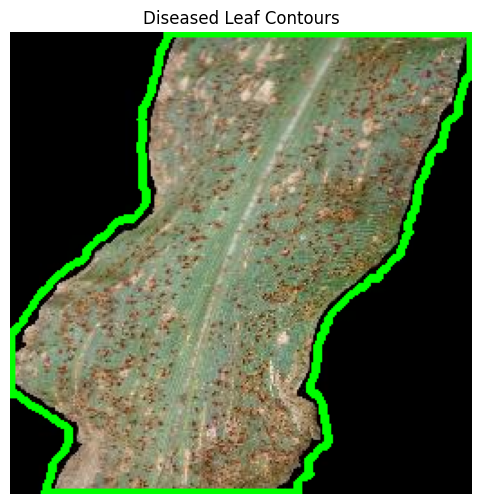

In [9]:
# --- Contour detection on diseased segmentation ---
contours, _ = cv2.findContours(diseased_seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
diseased_contours = diseased_img.copy()
cv2.drawContours(diseased_contours, contours, -1, (0,255,0), 3)
show_image('Diseased Leaf Contours', diseased_contours)

In [10]:
# --- Calculate percentage of affected area ---
affected_pixels = cv2.countNonZero(diseased_seg)
total_pixels = diseased_seg.size
percentage_affected = (affected_pixels / total_pixels) * 100
print(f"Percentage of affected leaf area: {percentage_affected:.2f}%")


Percentage of affected leaf area: 63.85%


In [21]:
# Cell 4: Part B - Prepare dataset for classification

import pandas as pd

# Recursive function to gather image paths and labels from dataset folders
def load_dataset(base_path):
    classes = sorted(os.listdir(base_path))
    images = []
    labels = []
    for ix, cls in enumerate(classes):
        cls_folder = os.path.join(base_path, cls)
        for img_name in os.listdir(cls_folder):
            img_path = os.path.join(cls_folder, img_name)
            if img_path.endswith(('jpeg','jpg','png')):
                images.append(img_path)
                labels.append(cls)
    return images, labels

image_paths, labels = load_dataset(data_path)
print(f"Total images: {len(image_paths)} Classes: {set(labels)}")


Total images: 1659 Classes: {'Blight', 'Common_Rust', 'Healthy', 'Gray_Leaf_Spot'}


In [22]:
# Encode labels to integers
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels_enc = le.fit_transform(labels)


In [23]:

# Train/test split
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels_enc, test_size=0.2, stratify=labels_enc, random_state=42)

print(f"Training samples: {len(train_paths)}  Test samples: {len(test_paths)}")

Training samples: 1327  Test samples: 332


In [24]:
# Cell 5: Data generator for loading images on the fly

IMG_SIZE = 224  # EfficientNetB0 input size

def preprocess_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0
    return img

def data_generator(paths, labels, batch_size=32):
    while True:
        for i in range(0, len(paths), batch_size):
            batch_paths = paths[i:i+batch_size]
            batch_labels = labels[i:i+batch_size]
            batch_images = np.array([preprocess_image(p) for p in batch_paths])
            batch_labels_arr = np.array(batch_labels)
            yield batch_images, batch_labels_arr

train_gen = data_generator(train_paths, train_labels)
test_gen = data_generator(test_paths, test_labels)


In [25]:
# Cell 6: Build and compile EfficientNetB0 classification model

base_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                                  input_shape=(IMG_SIZE, IMG_SIZE,3),
                                                  pooling='avg',
                                                  weights='imagenet')

base_model.trainable = False  # Freeze base

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE,3))
x = base_model(inputs, training=False)
outputs = layers.Dense(len(set(labels)), activation='softmax')(x)
model = models.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 1280)           │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 5,124 (20.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [29]:
# --- New Cell: Calculate Class Weights ---
from sklearn.utils import class_weight

# 1. Get unique classes and calculate balanced weights
# train_labels is an array of integer-encoded labels (0, 1, 2, 3...)
classes = np.unique(train_labels)
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=train_labels
)

# 2. Convert to the dictionary format required by Keras: {0: weight0, 1: weight1, ...}
class_weights = dict(zip(classes, weights))

print("Calculated Class Weights (Class Index: Weight):")
print(class_weights)
print("Class Names:", le.classes_) # To check the order, e.g., 0=Blight, 3=Healthy

# The weight for 'Healthy' (the majority class) should be significantly < 1.0,
# and the disease classes should be > 1.0.

Calculated Class Weights (Class Index: Weight):
{np.int64(0): np.float64(1.501131221719457), np.int64(1): np.float64(3.6456043956043955), np.int64(2): np.float64(3.252450980392157), np.int64(3): np.float64(0.36336254107338445)}
Class Names: ['Blight' 'Common_Rust' 'Gray_Leaf_Spot' 'Healthy']


In [30]:
# Cell 7: Train model for 8-12 epochs

EPOCHS = 10
STEPS_PER_EPOCH = len(train_paths) // 32
VALIDATION_STEPS = len(test_paths) // 32

history = model.fit(train_gen,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS_PER_EPOCH,
                    validation_data=test_gen,
                    validation_steps=VALIDATION_STEPS)


Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 458ms/step - accuracy: 0.6744 - loss: 0.9610 - val_accuracy: 0.6900 - val_loss: 0.9329
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 400ms/step - accuracy: 0.6835 - loss: 0.9367 - val_accuracy: 0.6733 - val_loss: 0.9579
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 379ms/step - accuracy: 0.6932 - loss: 0.9177 - val_accuracy: 0.6833 - val_loss: 0.9419
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 388ms/step - accuracy: 0.6877 - loss: 0.9332 - val_accuracy: 0.6800 - val_loss: 0.9510
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 478ms/step - accuracy: 0.6675 - loss: 0.9632 - val_accuracy: 0.6933 - val_loss: 0.9253
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 378ms/step - accuracy: 0.6816 - loss: 0.9444 - val_accuracy: 0.6906 - val_loss: 0.9342
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 372ms/step - accuracy: 0.6816 - loss: 0.9382 - val_accuracy: 0.6906 - val_loss: 0.9437
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 364ms/step - accuracy: 0.6720 - loss: 0.9647 - val_accu

In [31]:
# Cell 8: Evaluate model: accuracy, F1-score, confusion matrix, classification report

# Predict on test set
test_batches = len(test_paths) // 32 + 1
pred_probs = model.predict(test_gen, steps=test_batches)
pred_labels = np.argmax(pred_probs, axis=1)

print("Classification Report:")
print(classification_report(test_labels[:len(pred_labels)], pred_labels, target_names=le.classes_))

11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 253ms/step
Classification Report:
                precision    recall  f1-score   support

        Blight       0.00      0.00      0.00        55
   Common_Rust       0.00      0.00      0.00        23
Gray_Leaf_Spot       0.00      0.00      0.00        26
       Healthy       0.69      1.00      0.81       228

      accuracy                           0.69       332
     macro avg       0.17      0.25      0.20       332
  weighted avg       0.47      0.69      0.56       332



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Weighted F1 Score: 0.5592


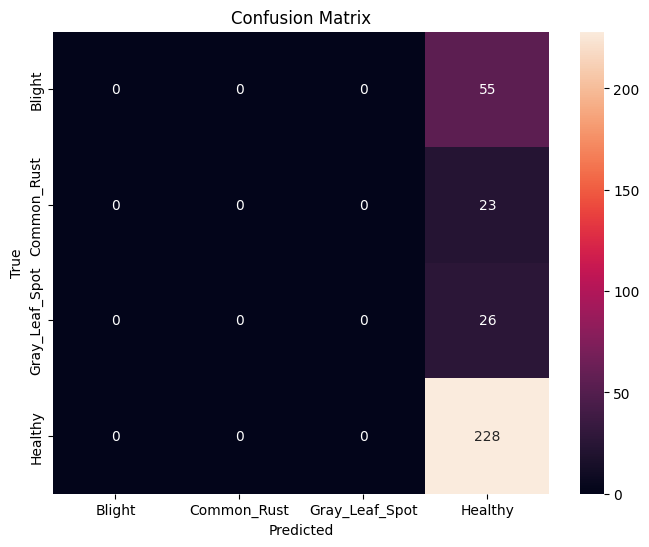

In [32]:
f1 = f1_score(test_labels[:len(pred_labels)], pred_labels, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")

cm = confusion_matrix(test_labels[:len(pred_labels)], pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


Correctly Classified Samples (5):


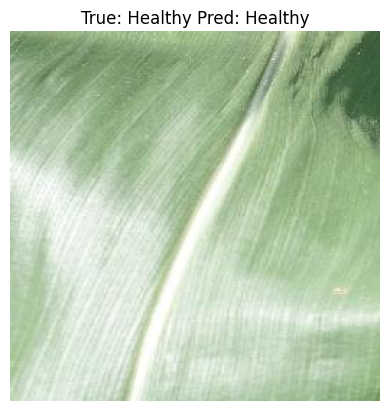

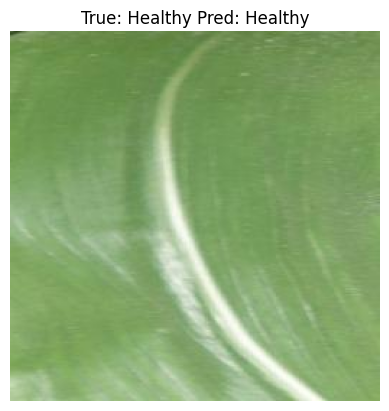

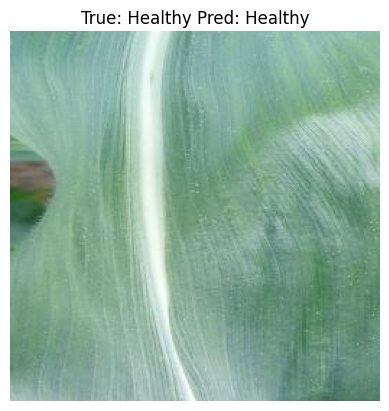

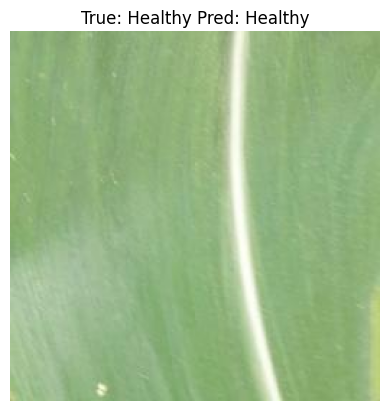

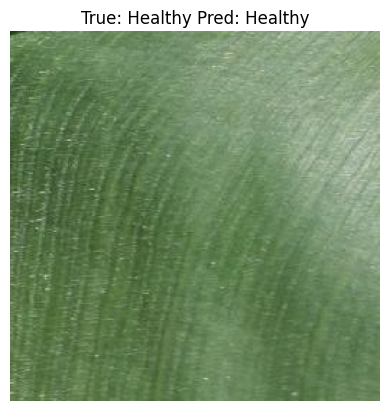

Incorrectly Classified Samples (5):


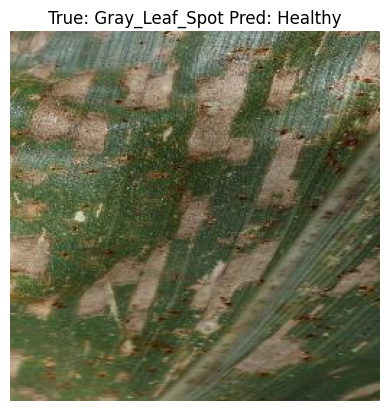

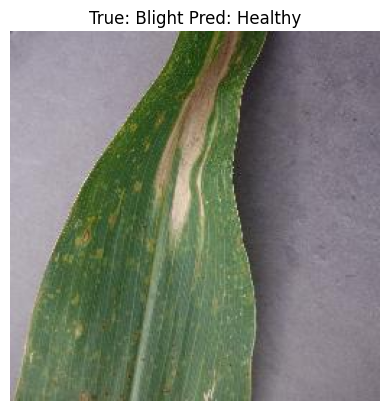

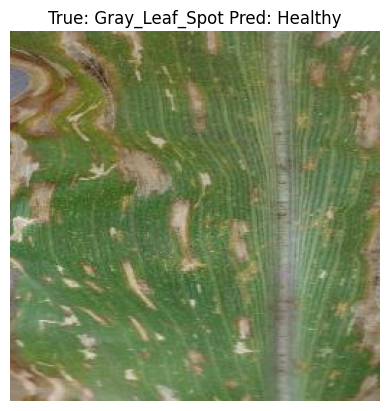

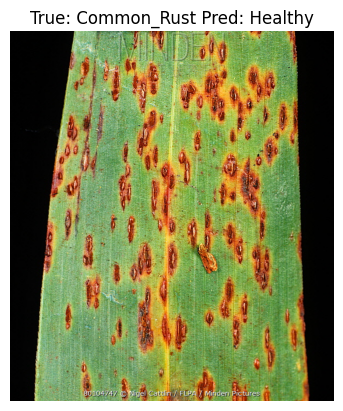

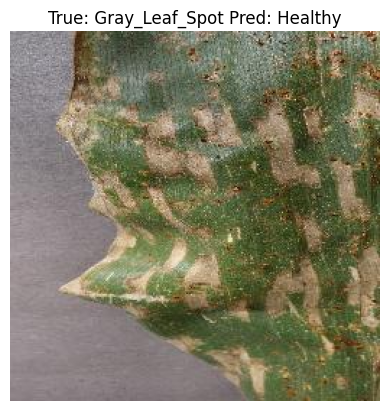

In [33]:
# Cell 9: Visualize correctly vs incorrectly classified samples

def visualize_results(paths, true_lbls, pred_lbls, class_names, num_samples=5):
    correct = []
    incorrect = []
    for p, t, pr in zip(paths, true_lbls, pred_lbls):
        if t == pr:
            correct.append((p, t, pr))
        else:
            incorrect.append((p, t, pr))

    print(f"Correctly Classified Samples ({min(num_samples,len(correct))}):")
    for i in range(min(num_samples,len(correct))):
        img = cv2.imread(correct[i][0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"True: {class_names[correct[i][1]]} Pred: {class_names[correct[i][2]]}")
        plt.axis('off')
        plt.show()

    print(f"Incorrectly Classified Samples ({min(num_samples,len(incorrect))}):")
    for i in range(min(num_samples,len(incorrect))):
        img = cv2.imread(incorrect[i][0])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.title(f"True: {class_names[incorrect[i][1]]} Pred: {class_names[incorrect[i][2]]}")
        plt.axis('off')
        plt.show()

visualize_results(test_paths[:len(pred_labels)], test_labels[:len(pred_labels)], pred_labels, le.classes_, num_samples=5)


In [20]:
# Cell 10: Discussion - How segmentation helps interpretation

print("""
Segmentation provides a focused region of interest by isolating diseased parts of the leaf. This helps the
classification model to potentially learn more disease-specific features by ignoring healthy background regions.
Moreover, segmentation serves as an explainability tool by highlighting affected areas, allowing users to visually
confirm what parts contribute to the model's decisions. Integrating segmentation with classification improves
interpretability and can guide more precise disease diagnosis and treatment in precision agriculture.
""")



Segmentation provides a focused region of interest by isolating diseased parts of the leaf. This helps the
classification model to potentially learn more disease-specific features by ignoring healthy background regions.
Moreover, segmentation serves as an explainability tool by highlighting affected areas, allowing users to visually
confirm what parts contribute to the model's decisions. Integrating segmentation with classification improves
interpretability and can guide more precise disease diagnosis and treatment in precision agriculture.

